In [ ]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from sklearn.preprocessing import minmax_scale
import matplotlib.pyplot as plt
import statsmodels.graphics.tsaplots as sgt
# metric -> profitabillty over options, direction prediction, SPA test to compare stats vs ML

In [ ]:

# Load the 5-year time series data of 8 variables into a pandas DataFrame
# df = pd.read_csv('vix_data.csv')
df = pd.read_csv('VIX Data - final.csv')
# df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.fillna(method='bfill')
df = df.drop(['Date'], axis=1)

df = df[::-1]
df.index = df.index[::-1]
df = df[:-1]
for column in df.columns:
    for row in df[column]:
        row = str(row)
        row = str(float(str(row).replace(',','')))


# cols = [x for x in df.columns if x != 'Volatility']
cols = [x for x in df.columns]

df[cols] = minmax_scale(df[cols])
# df = df[:1238]
data = df.values
np.savetxt('vix_data_updated.csv', data, delimiter=',', fmt='%.2f')

In [ ]:
timesteps = 400  # number of timesteps in the input sequence (1 year)
features = 8  # number of features in each timestep
output_timesteps = 7  # number of timesteps in the output sequence (7 days)
n_shift = 50

In [ ]:
df.head()

,Close,Volatility,Volume,Libor,US 10y Treasury yield,CBOE VIX,WTI Crude Oil Futures,Gold
0,0.136469,0.474489,0.054536,0.509255,0.790967,0.059958,0.589888,0.164102
1,0.135607,0.470158,0.081477,0.508153,0.806580,0.053556,0.586505,0.160254
2,0.138357,0.472594,0.071874,0.508766,0.787962,0.064456,0.587134,0.157664
3,0.144610,0.480985,0.082545,0.509316,0.822778,0.059701,0.599215,0.159588
4,0.145080,0.479903,0.074327,0.512802,0.846264,0.043292,0.602428,0.171799


In [ ]:
from keras.layers import GRU
def create_input_output_pairs(mydata, timesteps, features, output_timesteps, n_shift):
    X, y = [], []
    for i in range(len(mydata) - timesteps - output_timesteps + 1):
        if i % n_shift == 0:
            X.append(mydata[i:i+timesteps, :features])
            y.append(mydata[i+timesteps:i+timesteps+output_timesteps, 1])
    X = np.array(X)
    Y = np.array(y)
    print(X.shape, Y.shape)
    return X, Y

def make_train_test(X, y, train_percent=0.6):
    train_size = int(len(X) * train_percent)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]
    n_timesteps, n_features, n_outputs = X_train.shape[1], X_train.shape[2], y_train.shape[1]
    print(n_timesteps, n_features, n_outputs)
    return X_train, X_test, y_train, y_test

from tensorflow.keras.layers import Dense, Dropout, LSTM,Bidirectional


def model(n_timesteps, n_features, n_outputs):
    # Define the model
    model = Sequential()
    # model.add(LSTM(128, input_shape=(n_timesteps, n_features), return_sequences=True))
    model.add(GRU(128, input_shape=(n_timesteps, n_features)))
    # model.add(LSTM(64))
    Dropout(0.1),
    model.add(Dense(64))
    model.add(Dense(n_outputs))
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

def attention_model(n_timesteps, n_features, n_outputs):
    model = Sequential([
        Bidirectional(LSTM(units=256,input_shape=(n_timesteps, n_features), return_sequences=True)),
        # LSTM(units=128,input_shape=(n_timesteps, n_features), return_sequences=True),
        # gru(units=128,input_shape=(n_timesteps, n_features), return_sequences=True),
        # Dropout(0.1),
        LSTM(units=64,return_sequences=True),
        # GRU(units=64,return_sequences=True),
        # Dropout(0.1),
        Attention(),
        Dense(64),
        Dense(n_outputs)
    ])
    # Compile the model
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model

from sklearn.metrics import mean_squared_error, r2_score


# Evaluate the model on the test data
def evaluate_model(mymodel, X_test, y_test):
    # test_loss = mymodel.evaluate(X_test, y_test)
    # print(f'Test loss: {test_loss}')
    # Use the trained model to make predictions
    # predictions = []
    # for test in X_test:
    #   predictions.append(mymodel.predict(test))

    predictions = mymodel.predict(X_test)
    print(predictions.shape)
    arr1 = predictions[:,len(predictions[0])-1]
    arr2 = y_test[:,len(y_test[0])-1]
    print(arr1.shape)
    print(arr2.shape)
    arr1 = minmax_scale(arr1)
    arr2 = minmax_scale(arr2)
    # plot_predictions(arr1, arr2)
    plot_predictions2(arr1, arr2)
    print("mse = ",mean_squared_error(arr1,arr2))
    print("r2_score = ",r2_score(arr1,arr2))
    return [mean_squared_error(arr1,arr2),r2_score(arr1,arr2)]

def plot_predictions(predictions, y_test):
    plt.figure(figsize=(5, 5))
    plt.plot(y_test, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.legend()
    plt.show()

def plot_predictions2(predictions, y_test):
    ci = 0.05 * np.std(predictions) / np.mean(predictions)
    plt.figure(figsize=(5, 5))
    x = np.arange(0, len(predictions), 1)
    plt.plot(x,y_test, label='Actual')
    plt.plot(predictions, label='Predicted')
    plt.fill_between(x, (predictions-ci), (predictions+ci), color='red', alpha=0.05)
    plt.legend()
    plt.show()

In [ ]:
!pip install attention
from google.colab import output
output.clear()

In [ ]:
from attention import Attention

#LSTM

In [ ]:
X,y = create_input_output_pairs(data, 125, 8, 1, 1)
X_train, X_test, y_train, y_test = make_train_test(X, y, train_percent = 0.85)
modell = model(X_train.shape[1], X_train.shape[2], y_train.shape[1])

(3586, 125, 8) (3586, 1)
125 8 1


In [ ]:
modell.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 128)               52992     
                                                                 
 dense (Dense)               (None, 64)                8256      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 61,313
Trainable params: 61,313
Non-trainable params: 0
_________________________________________________________________


In [ ]:
modell.fit(X_train, y_train, epochs=60, batch_size=1, verbose=0)

17/17 [==============================] - 0s 3ms/step
(538, 1)
(538,)
(538,)


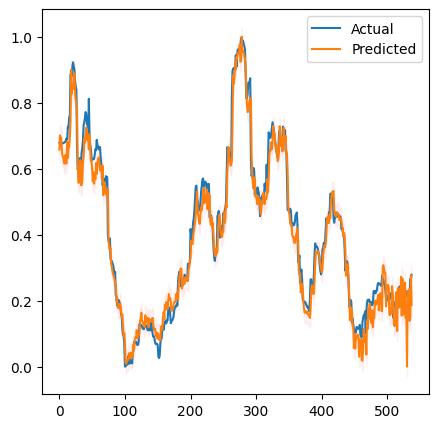

mse =  0.0022626284051256783
r2_score =  0.9599448881429573


In [ ]:
main_loss = evaluate_model(modell, X_test, y_test)

In [ ]:
def ciop(data2, mydata, timesteps, features, output_timesteps, n_shift):
    X, y = [], []
    for i in range(len(mydata) - timesteps - output_timesteps + 1):
        if i % n_shift == 0:
            X.append(mydata[i:i+timesteps, :features])
            y.append(data2[i+timesteps:i+timesteps+output_timesteps])
    X = np.array(X)
    Y = np.array(y)
    print(X.shape, Y.shape)
    return X, Y

In [ ]:
# now we will eliminate one feature at a time, revaluate input-output pairs, retrain the new model and plot the test loss vs feature eliminated
def loss_vs_eliminated_feature():
    yy = []
    for i in range(8):
        df2 = df.values
        data2 = df2[:,1]
        df1 = df.drop([df.columns[i]], axis=1)
        data1 = df1.values
        X1, y1 = ciop(data2, data1, 125, 7, 7, 50)
        # print(y1)
        X_train1, X_test1, y_train1, y_test1 = make_train_test(X1, y1, train_percent = 0.85)
        model1 = model(X_train1.shape[1], X_train1.shape[2], y_train1.shape[1])
        model1.fit(X_train1, y_train1, epochs=60, batch_size=1, verbose=0)
        mser2 = evaluate_model(model1, X_test1, y_test1)
        yy.append(mser2)
    return yy
yy = loss_vs_eliminated_feature()

In [ ]:
FII_LSTM = [];
for i in yy:
  FII_LSTM.append([i[0]-main_loss[0],main_loss[1]-i[1]])


In [ ]:
my_features = list(df.columns)

# plot the feature importance
plt.barh(my_features,np.array(FII_LSTM)[:,0])
plt.savefig('FeatureImportance_LSTM.png')
plt.show()

# plot the feature importance
plt.barh(my_features,np.array(FII_LSTM)[:,1])
plt.savefig('FeatureImportance_LSTM.png')
plt.show()

In [ ]:
df.columns

In [ ]:
# plot the test loss vs feature eliminated
xx = df.columns
plt.plot(xx,yy)

In [ ]:
# now we will eliminate two features at a time, revaluate input-output pairs, retrain the new model and plot the test loss vs features eliminated
df2 = df.values
data2 = df2[:,2]
df1 = df.drop([df.columns[1],df.columns[6]], axis=1)
data1 = df1.values
X1, y1 = ciop(data2, data1, 400, 6, 7, 50)
# print(y1)
X_train1, X_test1, y_train1, y_test1 = make_train_test(X1, y1, train_percent = 0.85)
model1 = model(X_train1.shape[1], X_train1.shape[2], y_train1.shape[1])
model1.fit(X_train1, y_train1, epochs=100, batch_size=1, verbose=0, callbacks=[callback])
evaluate_model(model1, X_test1, y_test1)

In [ ]:
# plot test-loss vs no. of epoch (10-200) by training various models with different number of epochs

def plot_loss_vs_epochs(X_train, X_test, y_train, y_test, epochs):
    test_loss = []
    for i in epochs:
        modelE = model(X_train.shape[1], X_train.shape[2], y_train.shape[1])
        modelE.fit(X_train, y_train, epochs=i, batch_size=1, verbose=0)
        test_loss.append(evaluate_model(modelE, X_test, y_test))
    return test_loss
# plot test-loss vs no. of epoch (10-200) by training various models with different number of epochs
epochs = [10, 20, 40, 50, 60, 70, 80, 100, 120, 150, 200]
test_loss_epochs = plot_loss_vs_epochs(X_train, X_test, y_train, y_test, epochs)

In [ ]:

plt.plot(epochs, np.array(test_loss_epochs)[:,0])
plt.xlabel('No. of epochs')
plt.ylabel('Test loss')
plt.show()

In [ ]:
plt.plot(epochs, np.array(test_loss_epochs)[:,1])
plt.xlabel('No. of epochs')
plt.ylabel('R2_Score')
plt.show()

In [ ]:
# now we change the number of timesteps and n_shift and plot the test loss vs timesteps - [62(1 quarter),125(6 months),250(1 year),375(1.5 years),500(2 years)]
def plot_loss_vs_timesteps(mydata, timesteps_list, n_shift_list):
    test_loss = []
    for i in timesteps_list:
        for j in n_shift_list:
            X, y = create_input_output_pairs(mydata, i, 8, 1, j)
            X_train, X_test, y_train, y_test = make_train_test(X, y, train_percent = 0.85)
            modelT = model(X_train.shape[1], X_train.shape[2], y_train.shape[1])
            modelT.fit(X_train, y_train, epochs=60, batch_size=1, verbose=0)
            test_loss.append(evaluate_model(modelT,X_test, y_test))
    return test_loss

timesteps_list = [62, 125, 250, 375, 500]
n_shift_list = [1,5,10,25,50]

test_loss_timesteps = plot_loss_vs_timesteps(data, timesteps_list, n_shift_list)

In [ ]:
test_loss_timesteps = [[[0.002044826762783154,0.9728810252966757],[0.002044826762783154,0.9728810252966757],[0.0061797276736761985,0.9084206044593992],[0.013326666116512583,0.7801618557123302],[0.0054089587787063565,0.9456863122689008]],
                       [[0.005211715805121035,0.9534985632941553],[0.001826060221119383,0.972417652748652],[0.0015766184309574274,0.9791387140405262],[0.0031629835986792115,0.9580503662475954],[0.002576990873065155,0.9724986012223827],[0.001089775078307632,0.9925083486748266]],
                       [[0.002454342589220678,0.9701747599057566],[0.003140760821674131,0.963899711990355],[0.004769009340212767,0.9436740653363154],[0.0014136549395422802,0.9863366489904521],[0.0013819996227033974,0.9902722606531853]],
                       [[0.0030851838801692804,0.9635352586666929],[0.004273549744505125,0.9541504708786782],[0.00625960691401932,0.9372028054099011],[0.000501149853281368,0.9952354380634586],[0.002343131928963218,0.9858876452808273]],
                       [[0.004254263550738416,0.923842752357237],[0.0031142236720269954,0.9477047985958168],[0.003653151198864994,0.9535071493208306],[0.003255785057876013,0.9787996702335341],[0.004982584521159811,0.9716735880248168]]]


In [ ]:
test_loss_timesteps_mse = []
for time_step in range(5):
    test_loss_timesteps_mse.append([0,0,0,0,0])
    for ns in range(5):
        test_loss_timesteps_mse[time_step][ns] = test_loss_timesteps[time_step][ns][0]

test_loss_timesteps_r2 = []
for time_step in range(5):
    test_loss_timesteps_r2.append([0,0,0,0,0])
    for ns in range(5):
        test_loss_timesteps_r2[time_step][ns] = test_loss_timesteps[time_step][ns][1]

In [ ]:
# now plot a 2d heatmap of test loss vs timesteps and n_shift
plt.imshow(test_loss_timesteps_mse, cmap='hot', interpolation='nearest')
cbar = plt.colorbar()  # Add color scale
plt.xlabel('N_shift')  # Add x-axis label
plt.ylabel('input_days')  # Add x-axis label
plt.yticks(np.arange(len(timesteps_list)), timesteps_list)
plt.xticks(np.arange(len(n_shift_list)), n_shift_list)
plt.title('MSE Variations')  # Add title
plt.show()
plt.imshow(test_loss_timesteps_r2, cmap='hot', interpolation='nearest')
plt.colorbar()  # Add color scale
plt.xlabel('N_shift')  # Add x-axis label
plt.ylabel('input_days')  # Add x-axis label
plt.yticks(np.arange(len(timesteps_list)), timesteps_list)
plt.xticks(np.arange(len(n_shift_list)), n_shift_list)
plt.title('R2 values Variations')  # Add title
plt.show()

In [ ]:
test_loss_timesteps

In [ ]:
XXX, yyy = create_input_output_pairs(data, 250, 8, 7, 25)
X_tr, X_te, y_tr, y_te = make_train_test(XXX, yyy, train_percent = 0.85)
modelTT = model(X_tr.shape[1], X_tr.shape[2], y_tr.shape[1])
modelTT.fit(X_tr, y_tr, epochs=100, batch_size=1, verbose=0)
LL = evaluate_model(modelTT,X_te, y_te)

#other

In [ ]:
# Now use Linear Regression to predict the VIX

# import the required libraries
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.metrics import mean_squared_error, r2_score

# make input-output pairs

def LR_create_input_output_pairs(mydata, output_timesteps, length):
    X, y = [], []
    for i in range(len(mydata) - length - output_timesteps + 1):
        X.append(mydata[i:i+length, :])
        y.append(mydata[i+length:i+length+output_timesteps, 1])
    X = np.array(X)
    Y = np.array(y)
    print(X.shape, Y.shape)
    return X, Y

In [ ]:
data.shape

(3711, 8)

In [ ]:
# create input-output pairs
df2 = df
cols = [x for x in df2.columns]
df2[cols] = minmax_scale(df2[cols])
df2.drop(index=df2.index[0], axis=0, inplace=True)
LR_data = df2.values
LR_X, LR_Y = LR_create_input_output_pairs(LR_data, 1, 125)
# split the data into train and test
LR_X_train, LR_X_test, LR_Y_train, LR_Y_test = make_train_test(LR_X, LR_Y, 0.85)

nsamples, nx, ny = LR_X_train.shape
d2_LR_X_train = LR_X_train.reshape((nsamples,nx*ny))
nsamples, nx, ny = LR_X_test.shape
d2_LR_X_test = LR_X_test.reshape((nsamples,nx*ny))

(3584, 125, 8) (3584, 1)
125 8 1


# Linear Regression

In [ ]:
# create a linear regression model
LR_model = Ridge(alpha = 0.5)
# train the model
LR_model.fit(d2_LR_X_train, LR_Y_train)
# predict the output
LR_Y_pred = LR_model.predict(d2_LR_X_test)

Mean squared error:  0.0014904150334747854
R2 score:  0.7041175816777869


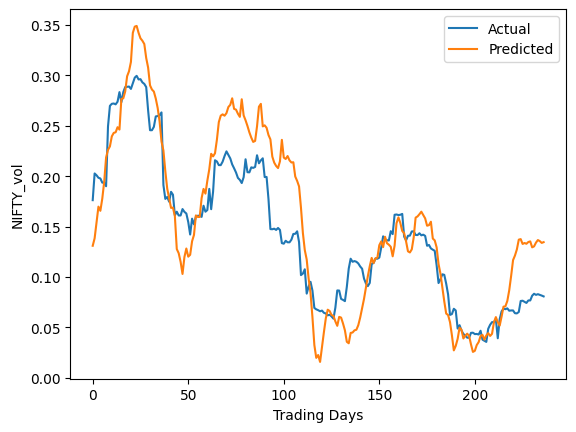

In [ ]:
# calculate the mean squared error
LR_mse = mean_squared_error(LR_Y_test[:,len(LR_Y_test[0])-1], LR_Y_pred[:,len(LR_Y_test[0])-1])
# calculate the r2 score
LR_r2 = r2_score(LR_Y_test[:,len(LR_Y_test[0])-1], LR_Y_pred[:,len(LR_Y_test[0])-1])
print('Mean squared error: ', LR_mse)
print('R2 score: ', LR_r2)
# plot the predicted output vs actual output
plt.plot(LR_Y_test[:,len(LR_Y_test[0])-1], label='Actual')
plt.plot(LR_Y_pred[:,len(LR_Y_test[0])-1], label='Predicted')
plt.xlabel('Trading Days')
plt.ylabel('NIFTY_vol')
plt.legend()
plt.savefig('LinRegRidge.png')
plt.show()

In [ ]:
df.columns

Index(['Close', 'Volatility', 'Volume', 'Libor', 'US 10y Treasury yield',
       'CBOE VIX', 'WTI Crude Oil Futures', 'Gold'],
      dtype='object')

In [ ]:
coef = LR_model.coef_

# Calculate the feature importance

importance = np.abs(coef)
feature_importance = 100.0 * (importance / np.sum(importance))
FI = [0,0,0,0,0,0,0,0]
for i in range(400):
    FI[i%8]+=feature_importance.T[i]


In [ ]:
feature_importance.T.shape

(400, 7)

In [ ]:
FII = []

In [ ]:
for i in range(8):
    FII.append(FI[i][0])

In [ ]:
FII

[0.8563322868726524,
 1.2240825209924213,
 3.3487935314231123,
 1.0760680086429355,
 0.8207224749529145,
 1.2356134563780496,
 0.8207224749529084,
 1.2176198835832004]

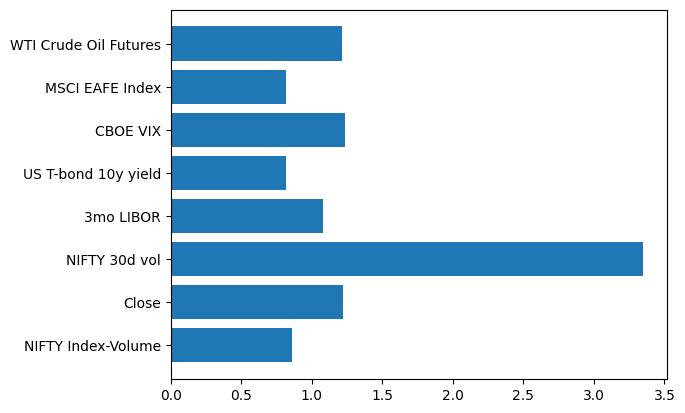

In [ ]:
my_features = ['NIFTY Index-Volume', 'Close', 'NIFTY 30d vol',
       '3mo LIBOR', 'US T-bond 10y yield', 'CBOE VIX', 'MSCI EAFE Index',
       'WTI Crude Oil Futures']

# plot the feature importance
plt.barh(my_features,FII)
plt.savefig('FeatureImportance_LR.png')
plt.show()

# Random Forrest

In [ ]:
# import the required libraries
from sklearn.ensemble import RandomForestRegressor

# create a random forest regression model
RF_model = RandomForestRegressor(n_estimators=100, random_state=0)
# train the model
RF_model.fit(d2_LR_X_train, LR_Y_train)
# predict the output
RF_Y_pred = RF_model.predict(d2_LR_X_test)
# calculate the mean squared error
RF_mse = mean_squared_error(LR_Y_test, RF_Y_pred)
# calculate the r2 score
RF_r2 = r2_score(LR_Y_test, RF_Y_pred)
print('Mean squared error: ', RF_mse)
print('R2 score: ', RF_r2)



<ipython-input-52-bc82f9554471>:7: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  RF_model.fit(d2_LR_X_train, LR_Y_train)


Mean squared error:  0.00036827982470171436
R2 score:  0.9255944950435524


In [ ]:
# Get feature importances
importances = RF_model.feature_importances_
feature_importance_RF = 100.0 * (importances / np.sum(importances))
FI_without_vol = [0,0,0,0,0,0,0]
FIRF = [0,0,0,0,0,0,0,0]
for i in range(1000):
    FIRF[i%8]+=feature_importance_RF.T[i]
    if(i%8!=1):
        if(i%8==0):
            FI_without_vol[0]+=feature_importance_RF.T[i]
        FI_without_vol[i%8-1]+=feature_importance_RF.T[i]

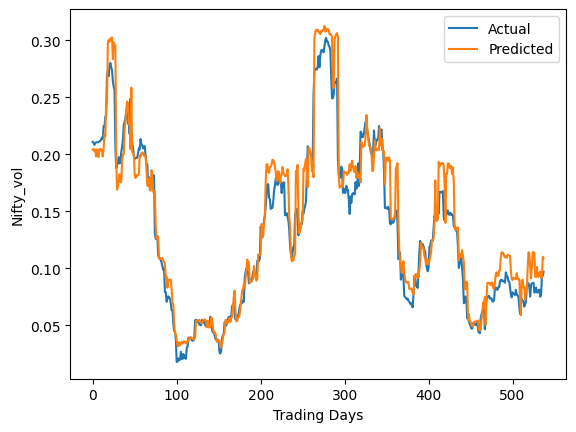

In [ ]:
# plot the predicted output vs actual output
plt.plot(LR_Y_test, label='Actual')
plt.plot(RF_Y_pred, label='Predicted')
plt.xlabel('Trading Days')
plt.ylabel('Nifty_vol')
plt.legend()
plt.savefig('RanFor.png')
plt.show()

In [ ]:
df.columns

Index(['Close', 'Volatility', 'Volume', 'Libor', 'US 10y Treasury yield',
       'CBOE VIX', 'WTI Crude Oil Futures', 'Gold'],
      dtype='object')

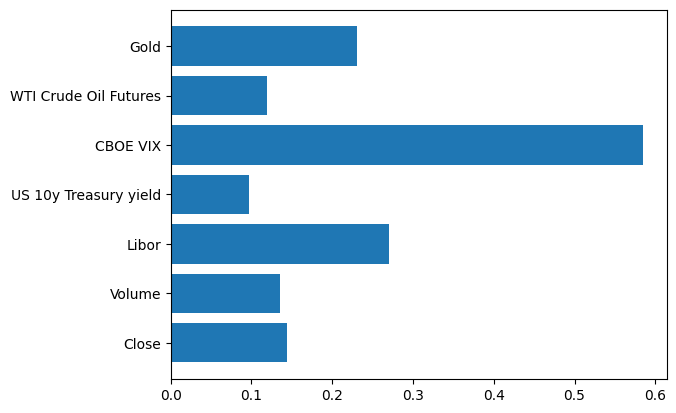

In [ ]:
my_features =['Close', 'Volume', 'Libor', 'US 10y Treasury yield',
       'CBOE VIX', 'WTI Crude Oil Futures', 'Gold']
# plot the feature importance
plt.barh(my_features,FI_without_vol)
plt.savefig('FeatureImportance_without_vol.png')
plt.show()

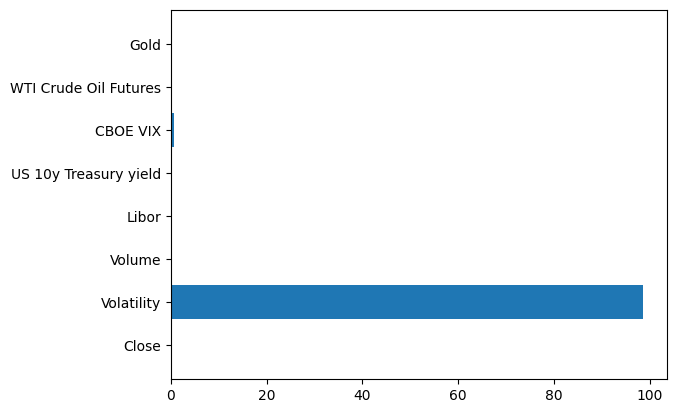

In [ ]:
my_features =['Close', 'Volatility', 'Volume', 'Libor', 'US 10y Treasury yield',
       'CBOE VIX', 'WTI Crude Oil Futures', 'Gold']
# plot the feature importance
plt.barh(my_features,FIRF)
plt.savefig('FeatureImportance_RF.png')
plt.show()

#ANN

In [ ]:

# Now use Artificial Neural Network to predict the VIX

# import the required libraries
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.callbacks import EarlyStopping

# create input-output pairs
ANN_X, ANN_Y = create_input_output_pairs(data, 62, 8, 1, 1)
# split the data into train and test
ANN_X_train, ANN_X_test, ANN_Y_train, ANN_Y_test = make_train_test(ANN_X, ANN_Y, train_percent = 0.85)
# convert into 1-dim
ANN_X_train = ANN_X_train.reshape(ANN_X_train.shape[0], ANN_X_train.shape[1]*ANN_X_train.shape[2])
ANN_X_test = ANN_X_test.reshape(ANN_X_test.shape[0], ANN_X_test.shape[1]*ANN_X_test.shape[2])
# create a sequential model
ANN_model = Sequential()
# add layers to the model and don't use LSTMs
ANN_model.add(Dense(32, input_dim=ANN_X_train.shape[1], activation='relu'))
ANN_model.add(Dense(16, activation='relu'))
ANN_model.add(Dense(8, activation='relu'))
ANN_model.add(Dense(4, activation='relu'))
ANN_model.add(Dense(ANN_Y_train.shape[1]))
# compile the model
ANN_model.compile(loss='mean_squared_error', optimizer='adam')
# train the model
ANN_model.fit(ANN_X_train, ANN_Y_train, epochs=50, batch_size=1, verbose=0)
# predict the output
ANN_Y_pred = ANN_model.predict(ANN_X_test)


(3649, 62, 8) (3649, 1)
62 8 1
18/18 [==============================] - 0s 1ms/step


In [ ]:
# calculate the mean squared error
# ANN_Y_test[:,0] = minmax_scale(ANN_Y_test[:,0])
# ANN_Y_test[:,1] = minmax_scale(ANN_Y_test[:,1])
# ANN_Y_test[:,2] = minmax_scale(ANN_Y_test[:,2])
# ANN_Y_pred[:,0] = minmax_scale(ANN_Y_pred[:,0])
# ANN_Y_pred[:,1] = minmax_scale(ANN_Y_pred[:,1])
# ANN_Y_pred[:,2] = minmax_scale(ANN_Y_pred[:,2])

ANN_mse = mean_squared_error(ANN_Y_test, ANN_Y_pred)
# calculate the r2 score
ANN_r2 = r2_score(ANN_Y_test, ANN_Y_pred)
print('Mean squared error: ', ANN_mse)
print('R2 score: ', ANN_r2)

Mean squared error:  0.00029096077816533826
R2 score:  0.9405332785763504


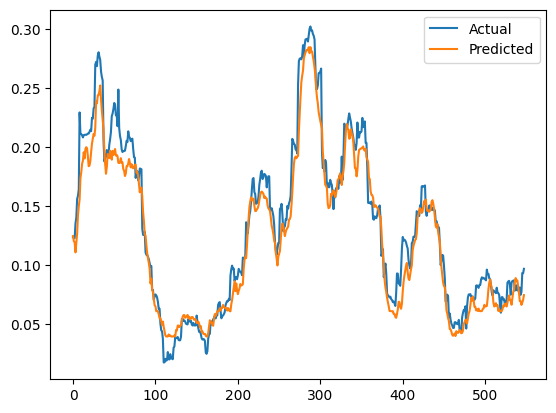

In [ ]:
# plot first arguement the predicted output vs actual output
plt.plot(ANN_Y_test, label='Actual')
plt.plot(ANN_Y_pred, label='Predicted')
# plt.plot(ANN_Y_pred[:,1], label='Predicted')
# plt.plot(ANN_Y_pred[:,2], label='Predicted')
plt.legend()
plt.savefig('ann.png')
plt.show()